In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import numpy as np
from b0.synth import (
    labels_to_chi, chi_to_fieldmap, fieldmap_to_shift, ppm_to_hz, shim)

In [2]:
aseg = f'samseg_talairach.mgz'

dat = nib.load(aseg)
dat = np.asarray(dat.dataobj).squeeze()
if not dat.dtype.isnative:
    dat = dat.newbyteorder()
dat = torch.as_tensor(dat)      # oriented [R A S]
zdim = -2                       # assumes B0 along A/P

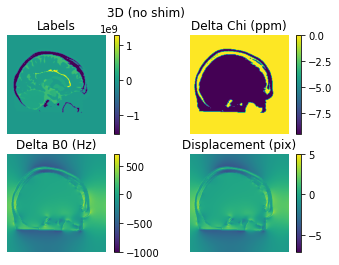

In [3]:
### 3D // no shim


chi = labels_to_chi(dat > 0)
fmap = chi_to_fieldmap(chi, dim=3, zdim=zdim)   # Assumes 1mm voxel
fmap = ppm_to_hz(fmap)                          # Assumes 3T / 1H
dmap = fieldmap_to_shift(fmap)                  # Assumes 140Hz/pix bandwidth

x = 148

plt.subplot(2, 2, 1)
plt.imshow(dat[x])
plt.colorbar()
plt.axis('off')
plt.title('Labels')
plt.subplot(2, 2, 2)
plt.imshow(chi[x])
plt.colorbar()
plt.axis('off')
plt.title('Delta Chi (ppm)')
plt.subplot(2, 2, 3)
plt.imshow(fmap[x])
plt.colorbar()
plt.axis('off')
plt.title('Delta B0 (Hz)')
plt.subplot(2, 2, 4)
plt.imshow(dmap[x])
plt.colorbar()
plt.axis('off')
plt.title('Displacement (pix)')
plt.suptitle('3D (no shim)')
plt.show()

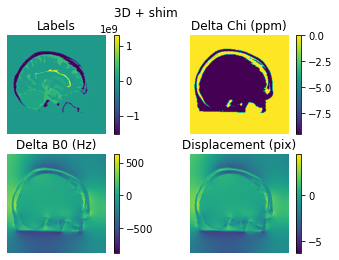

In [4]:
### 3D // with shim


chi = labels_to_chi(dat > 0)
fmap = chi_to_fieldmap(chi, dim=3, zdim=zdim)   # Assumes 1mm voxel
fmap = shim(fmap, mask=dat > 0, dim=3)          # Minimize grad in mask
fmap = ppm_to_hz(fmap)                          # Assumes 3T / 1H
dmap = fieldmap_to_shift(fmap)                  # Assumes 140Hz/pix bandwidth

x = 148

plt.subplot(2, 2, 1)
plt.imshow(dat[x])
plt.colorbar()
plt.axis('off')
plt.title('Labels')
plt.subplot(2, 2, 2)
plt.imshow(chi[x])
plt.colorbar()
plt.axis('off')
plt.title('Delta Chi (ppm)')
plt.subplot(2, 2, 3)
plt.imshow(fmap[x])
plt.colorbar()
plt.axis('off')
plt.title('Delta B0 (Hz)')
plt.subplot(2, 2, 4)
plt.imshow(dmap[x])
plt.colorbar()
plt.axis('off')
plt.title('Displacement (pix)')
plt.suptitle('3D + shim')
plt.show()


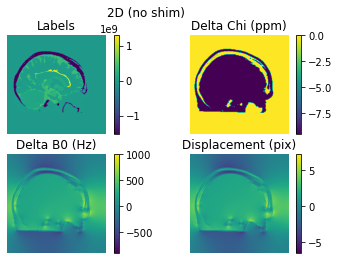

In [5]:
### 2D

dat = dat[x]
chi = labels_to_chi(dat > 0)
fmap = chi_to_fieldmap(chi, dim=2, zdim=zdim)
fmap = ppm_to_hz(fmap)
dmap = fieldmap_to_shift(fmap)


plt.subplot(2, 2, 1)
plt.imshow(dat)
plt.colorbar()
plt.axis('off')
plt.title('Labels')
plt.subplot(2, 2, 2)
plt.imshow(chi)
plt.colorbar()
plt.axis('off')
plt.title('Delta Chi (ppm)')
plt.subplot(2, 2, 3)
plt.imshow(fmap)
plt.colorbar()
plt.axis('off')
plt.title('Delta B0 (Hz)')
plt.subplot(2, 2, 4)
plt.imshow(dmap)
plt.colorbar()
plt.axis('off')
plt.title('Displacement (pix)')
plt.suptitle('2D (no shim)')
plt.show()